In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from network import Model

from scipy.stats import pearsonr
import json
from tools_lnd import rule_set_names, remove_ax_lines, remove_spines, remove_ticks

In [2]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','online_figs','fig3','fig3_C')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:
task_name_dict = {}
task_name_dict['Go'] = rule_set_names[0]
task_name_dict['RT Go'] = rule_set_names[1]
task_name_dict['Dly Go'] = rule_set_names[2]
task_name_dict['Anti'] = rule_set_names[3]
task_name_dict['RT Anti'] = rule_set_names[4]
task_name_dict['Dly Anti'] = rule_set_names[5]
task_name_dict['Dly DM 1'] = rule_set_names[6]
task_name_dict['Dly DM 2'] = rule_set_names[7]
task_name_dict['Ctx Dly DM 1'] = rule_set_names[8]
task_name_dict['Ctx Dly DM 2'] = rule_set_names[9]
task_name_dict['MultSen Dly DM'] = rule_set_names[10]
task_name_dict['DMS'] = rule_set_names[11]
task_name_dict['DNMS'] = rule_set_names[12]
task_name_dict['DMC'] = rule_set_names[13]
task_name_dict['DNMC'] = rule_set_names[14]

In [4]:
def plot_epoch_labels(ax, epoch_binary, which_axes = 'y', ms = .9):
    
    e_set = ['stim1','stim2','delay1','delay2','go1']
    e_color = plt.get_cmap('terrain')

    yl = np.max(ax.get_ylim())+2
    xl = np.max(ax.get_xlim())+2
    
    for ei in range(len(e_set)):
        e_name = e_set[ei]
        where = np.where(epoch_binary[e_name])[0]-.7
        c = e_color(ei/len(e_set))
        
        if 'y' in which_axes:
            
            ax.plot(np.where(epoch_binary[e_name])[0],
                     yl*np.ones(np.sum(epoch_binary[e_name])),'s',
                     color = c,markersize = ms,label = e_name)

            for w in where:
            
                rect = patches.Rectangle((w, yl), 1, 3,linewidth=ms, edgecolor=c, facecolor=c)
                ax.add_patch(rect)
            
        if 'x' in which_axes:
            
            ax.plot(xl*np.ones(np.sum(epoch_binary[e_name])),
                     np.where(epoch_binary[e_name])[0],'s',
                     color = c,markersize = ms,label = e_name)
            
            for w in where:
                rect = patches.Rectangle((xl, w), 3, 1,linewidth=ms, edgecolor=c, facecolor=c)
                ax.add_patch(rect)
            
            
def plot_epoch_rects(ax, epoch_binary, e_set, which_axes = 'y', rect_height = 1, rect_width = 58, ll = []):
    e_color = plt.get_cmap('terrain')

    if len(ll)>0:
        xl = ll[1]
        yl = ll[0]
    else:
        yl = np.max(ax.get_ylim())+2
        xl = np.max(ax.get_xlim())+2

        
    for ei in range(len(e_set)):
        e_name = e_set[ei]
        c = e_color(ei/len(e_set))
        
        if 'y' in which_axes:
            
            for ind in np.where(epoch_binary[e_name])[0]:
                rect=mpatches.Rectangle((ind-.5,yl),rect_height,rect_width,
                                        fill=True,color=c,facecolor=c,alpha = .3,clip_on=False)
                plt.gca().add_patch(rect)
            
        if 'x' in which_axes:
            
            for ind in np.where(epoch_binary[e_name])[0]:
                rect=mpatches.Rectangle((xl,ind-.5),rect_height,rect_width,
                                        fill=True,color=c,facecolor=c,alpha = .3,clip_on=False)
                plt.gca().add_patch(rect)
        

In [5]:
# from scipy.cluster import hierarchy
# color_palette = ['k','c', 'm', 'y']
# hierarchy.set_link_color_palette(color_palette)

In [6]:
##################################################################
#Find right model dir
##################################################################
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
method = 'ward'
max_d = 3.5
sparsity_threshold = .15
ex_1 = 1
ex_2 = 6
ex_3 = 8
al = .3
seed_set = [str(0),str(1),str(2)]#[str(0),str(1)]

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

n_tasks = str(len(rule_trains))
n_rnn = 128
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = 1
lr = -6
sigma_rec = 1/20
sigma_x = 2/20
pop_rule = 5
ruleset = 'all'
w_rec_coeff  = 8/10
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder_all = 'data/rnn/multitask/stepnet/'

# identify master network to compare other networks to. can be chosen randomly
rnn_type_master = 'LeakyRNN'
activation_master = 'softplus'
w_init_master = 'diag'
label_master = ' '.join([rnn_type_master,activation_master,w_init_master])
seed_master = str(1)
# m_master = os.path.join(p,data_folder_all,'final1',rnn_type_master,activation_master,w_init_master,
#                         n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed_master)

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)

net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

m_master = os.path.join(p,'data','rnn','multitask',net,'final1',ruleset,rnn_type_master,activation_master,
    w_init_master,str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name+net_name2,str(seed))

lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+'distance'+'_max_d'+str(max_d)
save_dir = os.path.join(m_master,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
feature_names_master = cluster_var['tick_names']

# set of networks to compare
rnn_type_set = ['LeakyGRU','LeakyRNN']
activation_set = ['tanh','retanh','softplus']
w_init_set = ['diag','randgauss']
data_folder_set = ['final1','untrained']
color_set = {}
color_set['final1'] = 'k'
color_set['untrained'] = 'dodgerblue'
color_set['no_noise'] = 'orangered'

tril_corr_mat_ave = {}

for rnn_type_i in range(len(rnn_type_set)):
    
    rnn_type = rnn_type_set[rnn_type_i]
    tril_corr_mat_ave[rnn_type] = {}
    
    for activation_i in range(len(activation_set)):
        
        activation = activation_set[activation_i]
        tril_corr_mat_ave[rnn_type][activation]= {}
        
        for w_init_i in range(len(w_init_set)):
            
            w_init = w_init_set[w_init_i]
            tril_corr_mat_ave[rnn_type][activation][w_init] = {}

            for data_folder in data_folder_set:
                
                tril_corr_mat_ave[rnn_type][activation][w_init][data_folder] = {}

                for seed in seed_set:
                    
                    if data_folder=='no_noise':
                        l2w = -0
                        l2h = -0
                    else:
                        l2w = -6
                        l2h = -6
                        
                    if (rnn_type == 'LeakyRNN') & (activation == 'tanh') & (data_folder == 'final1'):
                        w_rec_coeff  = 1
                        lr = -8
                    else:
                        w_rec_coeff  = 8/10
                        lr = -6
                        
                    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)

                    net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

                    m = os.path.join(p,'data','rnn','multitask',net,data_folder,ruleset,
                                            rnn_type,activation,w_init,str(len(rule_trains))+'_tasks',
                                            str(n_rnn)+'_n_rnn',net_name+net_name2,str(seed))

                    #load atlas data
                    save_dir = os.path.join(m,lesion_folder)
                    cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
                    D = cluster_var['D'].T
                    feature_names_original = [cluster_var['tick_names'][s] for s in 
                                              range(len(cluster_var['tick_names']))]

                    feat_order = [feature_names_original.index(s) for i,s in enumerate(feature_names_master)]
                    X = D[:,feat_order]
                    corr_mat = np.corrcoef(X.T)

                    if seed==seed_set[0]:
                        corr_mat_stack = corr_mat[:,np.newaxis]
                    else:
                        corr_mat_stack = np.concatenate((corr_mat_stack,corr_mat[:,np.newaxis]),axis=1)
            
                corr_mat_ave = np.mean(corr_mat_stack,axis = 1)
                tril_corr_mat_ave[rnn_type][activation][w_init][data_folder] = corr_mat_ave[np.tril_indices(len(corr_mat_ave),-1)]

In [7]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/'
lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
save_dir = os.path.join(m,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))

feature_names_master = cluster_var['tick_names']


In [8]:
feature_names_master

array(['DMS delay1', 'DMS go1', 'RT Go go1', 'DMC go1', 'DNMC go1',
       'DNMS delay1', 'DNMS go1', 'Dly DM 2 stim2', 'Ctx Dly DM 2 stim2',
       'Dly DM 1 stim2', 'Ctx Dly DM 1 stim2', 'MultSen Dly DM stim2',
       'DMS stim1', 'DMC stim1', 'Go stim1', 'Dly Go stim1',
       'Ctx Dly DM 2 stim1', 'Ctx Dly DM 1 stim1', 'MultSen Dly DM stim1',
       'Dly DM 1 stim1', 'Dly DM 2 stim1', 'RT Anti go1', 'DMC delay1',
       'DNMC delay1', 'Anti stim1', 'Dly Anti stim1', 'DNMS stim1',
       'DNMC stim1', 'Ctx Dly DM 2 go1', 'Ctx Dly DM 1 go1',
       'MultSen Dly DM go1', 'Anti go1', 'Go go1', 'Dly DM 1 go1',
       'Dly DM 2 go1', 'Dly Go go1', 'Dly Anti go1',
       'MultSen Dly DM delay2', 'Ctx Dly DM 1 delay1',
       'MultSen Dly DM delay1', 'Dly DM 1 delay1', 'Dly DM 2 delay1',
       'Ctx Dly DM 1 delay2', 'Ctx Dly DM 2 delay1',
       'Ctx Dly DM 2 delay2', 'Dly Anti delay1', 'Dly Go delay1',
       'Dly DM 1 delay2', 'Dly DM 2 delay2'], dtype='|S21')

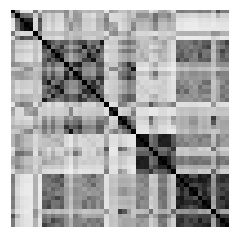

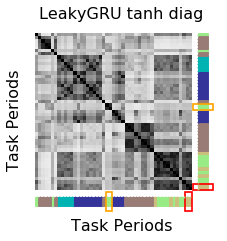

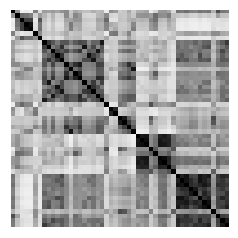

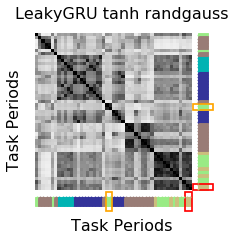

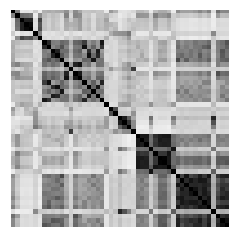

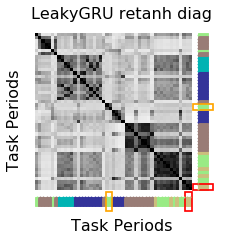

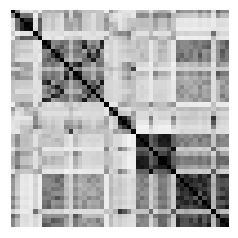

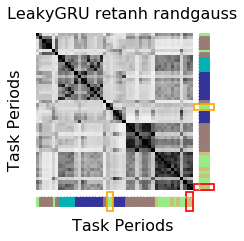

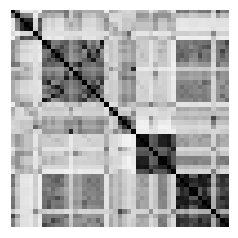

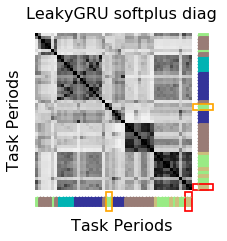

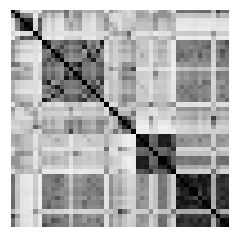

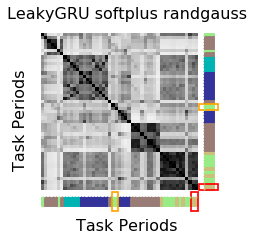

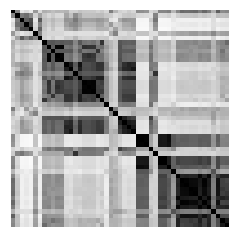

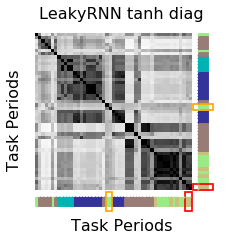

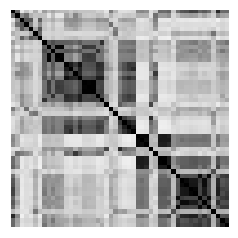

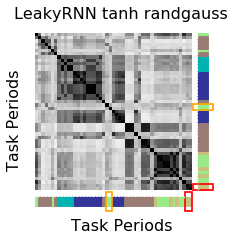

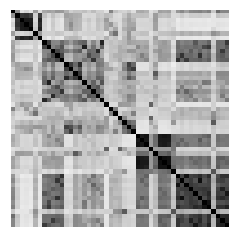

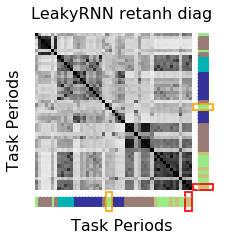

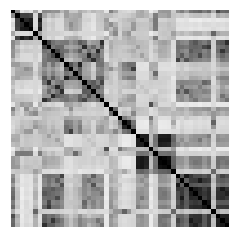

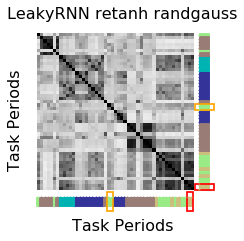

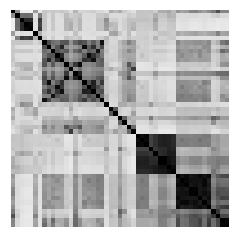

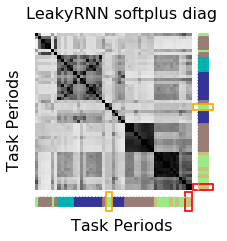

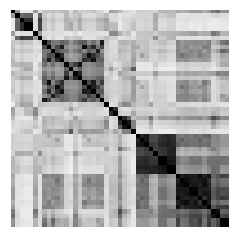

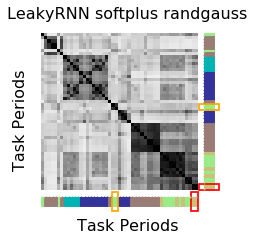

In [9]:
#MAKE COR MATS
# set of networks to compare
import matplotlib.patches as patches
rnn_type_set = ['LeakyGRU','LeakyRNN']
activation_set = ['tanh','retanh','softplus']
w_init_set = ['diag','randgauss']
data_folder_set = ['final1', ]# 

feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]
len_te = len(feature_names_labels)
epoch_binary = {}
for e_name in ['delay1','delay2','go1','stim1','stim2']:
    epoch_binary[e_name] = [feat_name.rsplit(' ', 1)[-1]==e_name for 
                            feat_name in feature_names_master]
    
method = 'ward'
criterion = 'distance'
cel_max_d = '3.5'
lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+criterion+'_max_d'+str(cel_max_d)
# m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/'

for rnn_type_i in range(len(rnn_type_set)):
    for activation_i in range(len(activation_set)):
        for w_init_i in range(len(w_init_set)):
            for data_folder in data_folder_set:
            
                rnn_type = rnn_type_set[rnn_type_i]
                activation = activation_set[activation_i]
                w_init = w_init_set[w_init_i]

                for seed in seed_set:
                    
                    if data_folder=='no_noise':
                        l2w = -0
                        l2h = -0
                    else:
                        l2w = -6
                        l2h = -6
                        
                    if (rnn_type == 'LeakyRNN') & (activation == 'tanh') & (data_folder == 'final1'):
                        w_rec_coeff  = 1
                        lr = -8
                    else:
                        w_rec_coeff  = 8/10
                        lr = -6
                        
                    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)

                    net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

                    m = os.path.join(p,'data','rnn','multitask',net,data_folder,ruleset,
                                            rnn_type,activation,w_init,str(len(rule_trains))+'_tasks',
                                            str(n_rnn)+'_n_rnn',net_name+net_name2,str(seed))
                    #load atlas data
                    save_dir = os.path.join(m,lesion_folder)
                    cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
                    D = cluster_var['D'].T
                    feature_names_original = [cluster_var['tick_names'][s] for s in range(len(cluster_var['tick_names']))]

                    feat_order = [feature_names_original.index(s) for i,s in enumerate(feature_names_master)]
                    X = D[:,feat_order]

                    corr_mat = np.corrcoef(X.T)

                    if seed==seed_set[0]:
                        corr_mat_stack = corr_mat[:,np.newaxis]
                    else:
                        corr_mat_stack = np.concatenate((corr_mat_stack,corr_mat[:,np.newaxis]),axis=1)

                corr_mat_ave = np.mean(corr_mat_stack,axis = 1)

                
                fig = plt.figure(figsize=(4,4))
                ax = plt.subplot(111)
                plt.imshow(corr_mat_ave,cmap= 'Greys',clim = (-.5,1))
                remove_ax_lines(ax)
                ax.set_yticks([])
                ax.set_xticks([])
                
                figname = '_'.join([rnn_type,activation,w_init,data_folder])+'.pdf'
                full_figpath = os.path.join(figpath,'corr_mats_nolabels')
                if not os.path.exists(full_figpath):
                    os.makedirs(full_figpath)
                plt.savefig(os.path.join(full_figpath,figname))
                plt.show()

                
                fig = plt.figure(figsize=(3.5,3.5))
                ax = plt.subplot(111)
                plt.imshow(corr_mat_ave,cmap= 'Greys',clim = (-.5,1))
                label = ' '.join([rnn_type,activation,w_init])
                plt.title(label, fontsize = 16)
                


                feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]
                epoch_binary = {}
                for e_name in ['delay1','delay2','go1','stim1','stim2']:
                    epoch_binary[e_name] = [feat_name.rsplit(' ', 1)[-1]==e_name for 
                                            feat_name in feature_names_master]
                plot_epoch_labels(ax,epoch_binary,which_axes = 'xy')
                    
                #                 dmc_where = np.where(feature_names_master=='DMC delay1')[0][0]
                dmc_where = np.where([feat_name=='DMC delay1' for feat_name in feature_names_master])[0][0]-.5
                rect = patches.Rectangle((dmc_where, len(feature_names_master)), 2, 6, 
                                         linewidth=1.7, edgecolor='orange', facecolor='none')
                ax.add_patch(rect)
                rect = patches.Rectangle((len(feature_names_master), dmc_where), 6, 2, 
                                         linewidth=1.7, edgecolor='orange', facecolor='none')
                ax.add_patch(rect)
                
#                 memgo_where = np.where(feature_names_master=='Dly Go delay1')[0][0]
                memgo_where = np.where([feat_name=='Dly DM 1 delay2' for feat_name in feature_names_master])[0][0]-.5
                rect = patches.Rectangle((memgo_where,len(feature_names_master)), 2, 6, 
                                         linewidth=1.7, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                rect = patches.Rectangle((len(feature_names_master),memgo_where), 6, 2, 
                                         linewidth=1.7, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                
                plt.ylabel('Task Periods',fontsize = 16)
                plt.xlabel('Task Periods',fontsize = 16)
                remove_ax_lines(ax)
                ax.set_yticks([])
                ax.set_xticks([])
                
                remove_ticks(ax)
                remove_spines(ax)
                
                figname = '_'.join([rnn_type,activation,w_init,data_folder,seed])+'.pdf'
                full_figpath = os.path.join(figpath,'corr_mats_labels')
                if not os.path.exists(full_figpath):
                    os.makedirs(full_figpath)
                plt.savefig(os.path.join(full_figpath,figname),bbox_inches = 'tight')
                plt.show()
    
                corr_mat_stack = []

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


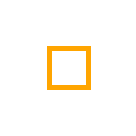

In [10]:
fig = plt.figure(figsize=(2,2),tight_layout=True,facecolor='white')
ax = plt.subplot(111)

dmc_where = np.where([feat_name=='DMC delay1' for feat_name in feature_names_master])[0][0]
rect = patches.Rectangle((0, 0), 1, 1, linewidth=5, edgecolor='orange', facecolor='none')
ax.add_patch(rect)

plt.xlim([-1,2])
plt.ylim([-1,2])
remove_spines(ax)
ax.set_yticks([])
ax.set_xticks([])

figname = 'dmc_box_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'dmc_box_legend.png'
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')
plt.show()

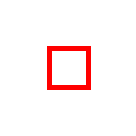

In [11]:
fig = plt.figure(figsize=(2,2),tight_layout=True,facecolor='white')
ax = plt.subplot(111)

memgo_where = np.where([feat_name=='Dly Go delay1' for feat_name in feature_names_master])[0][0]
rect = patches.Rectangle((0, 0), 1, 1, linewidth=5, edgecolor='red', facecolor='none')
ax.add_patch(rect)

plt.xlim([-1,2])
plt.ylim([-1,2])
remove_spines(ax)
ax.set_yticks([])
ax.set_xticks([])

figname = 'dlygo_box_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'dlygo_box_legend.png'
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')
plt.show()

In [12]:
from scipy.cluster import hierarchy
color_palette = ['b','c', 'm', 'y', 'r']
color_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                 '#e41a1c', '#dede00']
hierarchy.set_link_color_palette(color_palette)
alphabet = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 14:'n',
            15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t', 21:'u', 22:'v', 23:'w', 24:'x', 25:'y', 26:'z',
           27:'a', 28:'b', 29:'c', 30:'d', 31:'e', 32:'f', 33:'g', 34:'h', 35:'i', 36:'j', 37:'k', 38:'l', 39:'m', 
            40:'n', 41:'o', 42:'p', 43:'q', 44:'r', 45:'s', 46:'t', 47:'u', 48:'v', 49:'w', 50:'x', 51:'y', 52:'z'}

def make_cluster_midpoint_labels(clust):
    d = np.concatenate(([-1], np.where(np.diff(clust))[0],[len(clust)-1]),axis = 0)
    mid = np.zeros(len(d))
    cluster_size = np.zeros(len(d))
    for xi in range(len(d)-1):
        cluster_size[xi] = d[xi+1] - d[xi]
        mid[xi] = d[xi+1]-cluster_size[xi]/2+.5
    return cluster_size, mid


In [13]:
# set of networks to compare
rnn_type_set = ['LeakyRNN','LeakyGRU']
activation_set = ['softplus','tanh','retanh']
w_init_set = ['diag','randgauss']

seed_set = [str(0),str(1),]
max_d = 3.5
n_rnn = str(128)
x_ind_counter = 0
ax1_xticks = []
method = 'ward'
all_epochs = ['stim1','stim2','delay1','delay2','go1']

In [14]:
n_rnn = 128
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = 1
lr = -6
sigma_rec = 1/20
sigma_x = 2/20
pop_rule = 5
ruleset = 'all'
w_rec_coeff  = 8/10

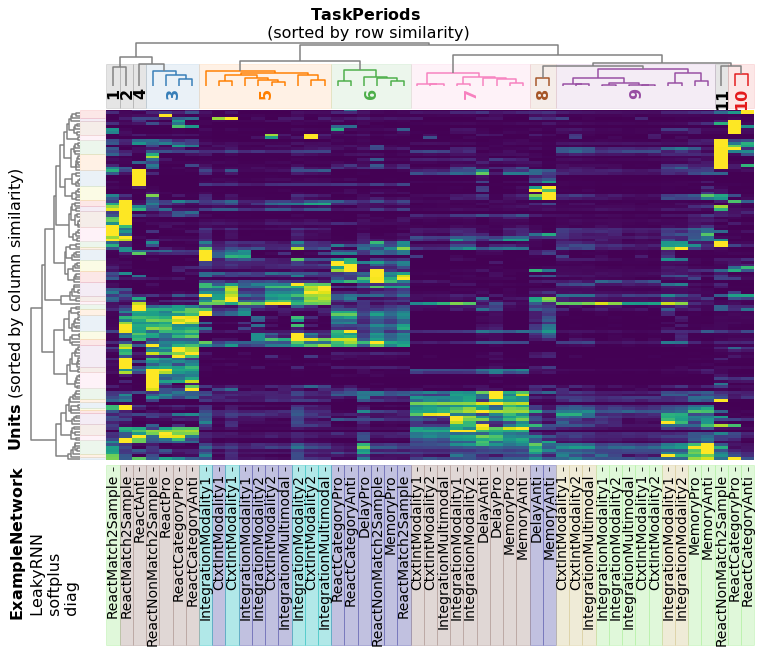

In [19]:
### load master network and make average correlation matrix across seeds

data_folder_set = ['final1',]
data_folder=data_folder_set[0]
######main LeakyRNN######
rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
seed = str(1)
# ########################
# ######supp examples######
# rnn_type = 'LeakyGRU'
# activation = 'softplus'
# w_init = 'diag'
# seed = 0
# # ########################
# rnn_type = 'LeakyGRU'
# activation = 'tanh'
# w_init = 'diag'
# seed = 0
# ########################
# rnn_type = 'LeakyRNN'
# activation = 'tanh'
# w_init = 'randgauss'
# seed = 0
# # ########################
# rnn_type = 'LeakyRNN'
# activation = 'retanh'
# w_init = 'randgauss'
# seed = 0
# # ########################

import matplotlib.patches as mpatches

# x-axis and labelling bs
if data_folder==data_folder_set[0]:
    x_ind_counter+=1
    label = ' '.join([rnn_type,activation,w_init])
    if len(ax1_xticks)==0:
        ax1_xticks = [label,]
    else:
        ax1_xticks.append(label)


if data_folder=='no_noise':
    l2w = -0
    l2h = -0
else:
    l2w = -6
    l2h = -6

if (rnn_type == 'LeakyRNN') & (activation == 'tanh') & (data_folder == 'final1'):
    w_rec_coeff  = 1
    lr = -8
else:
    w_rec_coeff  = 8/10
    lr = -6

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)

net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

m_master = os.path.join(p,'data','rnn','multitask',net,'final1',ruleset,
                        rnn_type,activation,w_init,str(len(rule_trains))+'_tasks',
                        str(n_rnn)+'_n_rnn',net_name+net_name2,str(seed))
label_master = ' '.join([rnn_type,activation,w_init,seed])

lesion_folder = 'lesion_fps_hierarchical_ward_maxclust_opt_clust'
save_dir = os.path.join(m_master,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
feature_names_master = cluster_var['tick_names']

feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]
epoch_binary = {}
for e_name in ['delay1','delay2','go1','stim1','stim2']:
    epoch_binary[e_name] = [feat_name.rsplit(' ', 1)[-1]==e_name for 
                            feat_name in feature_names_master]

D = cluster_var['D'].T
feature_names_original = [cluster_var['tick_names'][s] for s in range(len(cluster_var['tick_names']))]

feat_order = [feature_names_original.index(s) for i,s in enumerate(feature_names_master)]
X = D[:,feat_order]
#     X = D

#visualize atlas for master network
fig = plt.figure(figsize=(18,9))
plt.rcParams.update({'font.size': 16})
legend_done = 0
atlas_width = .55
atlas_height = .55
thresh = 4

axdendro_top = fig.add_axes([.06,atlas_height+.082,atlas_width-.05,.07])
Y = sch.linkage(X.T, method=method)
clusters_top = fcluster(Y, thresh, criterion=criterion)
Z_top = sch.dendrogram(Y, orientation='top',#labels = clusters, #CA.ind_active #clusters
                   leaf_font_size = 11,color_threshold=thresh,
                          above_threshold_color='gray', labels = clusters_top)

cluster_size,mid_top = make_cluster_midpoint_labels(clusters_top)
for xi in range(len(mid_top)-1):
    if cluster_size[xi]==1:
        c = 'k'
    else:
        color_ind = xi - np.sum(cluster_size[:xi]==1)
        c = color_palette[color_ind%len(color_palette)]
    clust_mid = mid_top[xi]
    rect=mpatches.Rectangle((5+10*(clust_mid-cluster_size[xi]/2),-5),cluster_size[xi]*10,10, 
    fill=True,color=c,facecolor=c,alpha = .1,clip_on=False)
    plt.gca().add_patch(rect)
    plt.text(clust_mid*10,-3,str(clusters_top[int(clust_mid)]),color=c,fontweight='bold',rotation = 90)
#                         plt.text(xi*10,-15,str(clusters_sorted[int(xi)]))

remove_spines(axdendro_top)
remove_ticks(axdendro_top)
axdendro_top.set_xticks([])

axdendro = fig.add_axes([0,.054,0.04,atlas_height*.98])
Y = sch.linkage(X, method=method)
clusters = cluster_var['clusters']
Z = sch.dendrogram(Y, orientation='left',#labels = clusters, #CA.ind_active #clusters
                   leaf_font_size = 11,color_threshold=0,above_threshold_color='gray', labels = clusters)

cluster_size, mid = make_cluster_midpoint_labels(clusters)
for xi in range(len(mid)-1):

    c = color_palette[xi%len(color_palette)]
    clust_mid = mid[xi]
    rect=mpatches.Rectangle((-5,10+10*(clust_mid-cluster_size[xi]/2)),5,cluster_size[xi]*10, 
    fill=True,
    color=c,facecolor=c,alpha = .1,clip_on=False)
    plt.gca().add_patch(rect)
#         plt.text(-1.5,10*clust_mid-20,alphabet[clusters[int(clust_mid)]],color =c,rotation = 90)

remove_spines(axdendro)
remove_ticks(axdendro)
axdendro.set_xticks([])


axmatrix = fig.add_axes([.06,0.045,atlas_width-.05,atlas_height])#fig.add_subplot(1,2,1)
index_top = Z['leaves']
X = X[index_top,:]
plt.imshow(X[-1:0:-1,:],cmap= 'viridis', aspect='auto')

len_te = len(feature_names_labels)
axmatrix.set_xticks(range(len_te))
task_labels = [task_name_dict[feat] for feat in feature_names_labels]
axmatrix.set_xticklabels(task_labels,fontsize = 14, rotation =90,ha = 'center')
#                     plot_epoch_labels(axmatrix,epoch_binary,which_axes = 'y',ms = 12.5)
plot_epoch_rects(axmatrix,epoch_binary,all_epochs,which_axes = 'y', rect_height = 1, rect_width = 65)

label_master_seed = ' '.join([rnn_type,activation,w_init]) 

plt.text(-8,len(X)/5,r"$\bf{Units}$"+' (sorted by column similarity)',rotation = 90)
plt.text(-8,1.2*len(X),r"$\bf{Example Network}$"+ ' \n '+' \n '.join(label_master_seed.split()),rotation = 90)
axmatrix.set_xlabel(r"$\bf{Task Periods}$"+ ' \n (sorted by row similarity)')
axmatrix.xaxis.set_label_coords(.4, 1.29)
remove_spines(axmatrix)
axmatrix.set_yticks([])
plt.ylim((len(X)+1,0))

# make subpanels.
sp_width = .14
sp_wide = .2
offset = .06

label = '_'.join([data_folder,rnn_type,activation,w_init,seed])
figname = 'atlas_'+label+'.pdf'
figpath_full = os.path.join(figpath,'atlas',data_folder)
if not os.path.exists(figpath_full):
    os.makedirs(figpath_full)
plt.savefig(os.path.join(figpath_full,figname),bbox_inches = 'tight')

plt.show()

In [28]:
epoch_set = ['Stimulus1','Stimulus2','Memory1','Memory2','Response']

epoch_b = {}

for e_ind in range(len(epoch_set)):
    epoch_b[epoch_set[e_ind]] = np.zeros(len(epoch_set))
    epoch_b[epoch_set[e_ind]][e_ind] = 1

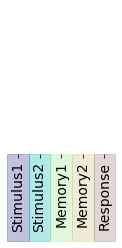

In [29]:
fig = plt.figure(figsize=(1.2,2))
ax = fig.add_axes([0,0,1,1])#fig.add_subplot(1,2,1)
ax.set_xticks(range(len(epoch_set)))
ax.set_xticklabels(epoch_set,fontsize = 14, rotation =90,ha = 'center')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
# ax.set_xticks([])
    
plot_epoch_rects(ax,epoch_b,epoch_set,which_axes = 'y', rect_height = 1, rect_width = .6, ll = [-.6,0])
plt.savefig(os.path.join(figpath_full,'legend.pdf'),bbox_inches = 'tight')

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/axis.py:1086: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/axis.py:1096: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


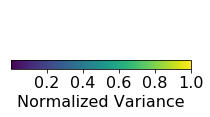

In [22]:
fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
ax = fig.add_axes([0, 0, 2.5, 1])
plt.imshow(X[-1:0:-1,:],cmap= 'viridis', aspect='auto')
plt.xlim([0,-.1])
plt.ylim([0,-.1])
remove_spines(ax)
ax.set_yticks([])
ax.set_xticks([])
cbar = plt.colorbar(orientation="horizontal",fraction=0.5,pad=.5,anchor=(-.15,.5))
cbar.set_label('Normalized Variance')

figname = 'var_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'var_legend.png'
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')
plt.show()